*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">NLP : Analyse de données textuelles </div>

*******

<div style="padding:20px;color:black;margin:0;font-size:150%;display:fill;border-radius:8px;background-color:#d9d9d9;overflow:hidden;font-weight:100"><strong>Présentation</strong></div>
<a class="anchor" id="Section_1.1"></a>

### Etude de faisabilité d'un moteur de classification, basé sur une description et sur une image

Cette étude vise à comparer deux approches, le notebook 1 classe les images selon leur description et le notebook 2 classe les images en utilisant une méthode de transfert Learning basée sur VGG16.      


Un prétraitement des données textuelles:
- enlever la **ponctuation**
- enlever les **chiffres**
- transformer les phrases en **liste de tokens** (en liste de mots)
- enlever les **stopwords** (mots n'apportant pas de sens)
- **lemmatizer**
- enlever les **majuscules**
- **reformer les phrases** avec les mots restants

Comparaison de 4 méthodes afin d’extraire les features texte :   
- Deux approches de type **bag-of-words**, comptage simple de mots et **Tf-idf** 
- Une approche de type word/sentence embedding classique avec **Word2Vec**
- Une approche de type word/sentence embedding avec **BERT** 
- Une approche de type word/sentence embedding avec **USE**(Universal Sentence Encoder)
  
Une réduction en 2 dimensions **T-SNE**, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle.             
Réalisation d’une mesure pour confirmer l'analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters, basée sur **l'ARI**.     
Démonstration, par cette approche, de la faisabilité de regrouper automatiquement des produits de même catégorie.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import time
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

In [2]:
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [3]:
# Importation des données
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv",sep=",")
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [4]:
df.shape

(1050, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

## Catégorie
Nous reccupérons le nom de la catégorie, qui se trouve en tête de la colonne product_category_tree

In [6]:
df_categ= df["product_category_tree"].str.split(pat=">>", expand=True)
df_categ

,0,1,2,3,4,5,6
0,"[""Home Furnishing",Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,"[""Home Furnishing",Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,"[""Home Furnishing",Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None
...,...,...,...,...,...,...,...
1045,"[""Baby Care",Baby & Kids Gifts,Stickers,"Oren Empower Stickers""]",None,None,None
1046,"[""Baby Care",Baby & Kids Gifts,Stickers,"Wallmantra Stickers""]",None,None,None
1047,"[""Baby Care",Baby & Kids Gifts,Stickers,"Uberlyfe Stickers""]",None,None,None
1048,"[""Baby Care",Baby & Kids Gifts,Stickers,"Wallmantra Stickers""]",None,None,None


In [7]:
df_categ = pd.DataFrame(data=df_categ.values,
                        columns=["categorie","x2","x3","x4","x5","x6","x7"])
df_categ = df_categ['categorie']
df_categ

0       ["Home Furnishing 
1             ["Baby Care 
2             ["Baby Care 
3       ["Home Furnishing 
4       ["Home Furnishing 
               ...        
1045          ["Baby Care 
1046          ["Baby Care 
1047          ["Baby Care 
1048          ["Baby Care 
1049          ["Baby Care 
Name: categorie, Length: 1050, dtype: object

In [8]:
for i in range(df_categ.shape[0]):
    df_categ.iloc[i] = df_categ.iloc[i].replace('\"',"")
    df_categ.iloc[i] = df_categ.iloc[i].replace('[',"")
df_categ = pd.DataFrame(data=df_categ.values,columns=["categorie"],index=df["uniq_id"])
df_categ

,categorie
uniq_id,
55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing
7b72c92c2f6c40268628ec5f14c6d590,Baby Care
64d5d4a258243731dc7bbb1eef49ad74,Baby Care
d4684dcdc759dd9cdf41504698d737d8,Home Furnishing
6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing
...,...
958f54f4c46b53c8a0a9b8167d9140bc,Baby Care
fd6cbcc22efb6b761bd564c28928483c,Baby Care
5912e037d12774bb73a2048f35a00009,Baby Care


In [9]:
# Pour la partie suivante : traitement des images,
# nous avons besoins de ce df

df_categ.to_csv("df_categ.csv",sep=";")

In [10]:
df_categ.value_counts()

categorie                  
Baby Care                      150
Beauty and Personal Care       150
Computers                      150
Home Decor & Festive Needs     150
Home Furnishing                150
Kitchen & Dining               150
Watches                        150
dtype: int64

## Fusion des colonnes product_name et description
Cette colonne servira de base pour l'analyse textuelle

In [11]:
df_com = df[["uniq_id", "product_name","description"]]
df_com

,uniq_id,product_name,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [12]:
df_com["description"]=df_com["product_name"]+ " " + df_com["description"]
df_com = df_com[["uniq_id", "description"]]
df_com = pd.DataFrame(data=df_com["description"].values,index=df_com["uniq_id"],columns=["description"])
df_com

C:\Users\fbbou\AppData\Local\Temp\ipykernel_10316\170799886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com["description"]=df_com["product_name"]+ " " + df_com["description"]


,description
uniq_id,
55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...
7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...
64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...
d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...
6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...
...,...
958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker...
fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker Wallman...
5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...


In [16]:
print(len(min(df_com['description']))

1025

In [17]:
len(max(df_com['description']))

2568

In [22]:
len(df_com['description'][0].split())

237

In [23]:
# Création d'une liste contenant le nombre de mot par description

list_nb_mots=[]
for i in range(df_com.shape[0]):
    a = len(df_com['description'][i].split())
print(list_nb_mots.append(a))

In [24]:
print("Nombre de mots max par description : ", max(list_nb_mots))
print("Nombre de mots min par description : ", min(list_nb_mots))

Nombre de mots max par description :  592
Nombre de mots min par description :  19


## Traitements du text
Nous construisons notre **fonction de preprocessing** qui va successivement :
- enlever la **ponctuation**
- enlever les **chiffres**
- transformer les phrases en **liste de tokens** (en liste de mots)
- enlever les **stopwords** (mots n'apportant pas de sens)
- **lemmatizer**
- enlever les **majuscules**
- **reformer les phrases** avec les mots restants

In [16]:
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fbbou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fbbou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fbbou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
french_stopwords = nltk.corpus.stopwords.words('french')
mots = set(line.strip() for line in open('dictionnaire.txt', encoding="utf-8"))
lemmatizer = FrenchLefffLemmatizer()

In [19]:
def French_Preprocess_listofSentence(listofSentence):
  preprocess_list = []
  for sentence in listofSentence :

    sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])

    sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

    tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

    words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]

    words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

    sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in mots or not w.isalpha())

    preprocess_list.append(sentence_clean)

  return preprocess_list

In [20]:
# création d'une liste de 1050 éléments composée de chaque description de produit
liste_bow = French_Preprocess_listofSentence(df_com["description"])

## Bag of word : comptage (ct) & TF-IDF (ctf)

In [21]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer( max_df=0.95, min_df=1)
ctf = TfidfVectorizer( max_df=0.95, min_df=1)

cv_fit = cvect.fit(liste_bow)
ctf_fit = ctf.fit(liste_bow)

cv_transform = cvect.transform(liste_bow)
ctf_transform = ctf.transform(liste_bow)

In [22]:
l_cat = list(set(df_categ["categorie"]))
y_cat_num = [(1-l_cat.index(df_categ.iloc[i]['categorie'])) for i in range(len(df_categ))]

In [23]:
# Création d'une fonction renvoyant :
# l'ARI les coordonnées des points via le T-SNE et le clustering

def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [24]:
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform)

ARI :  0.2587 time :  8.0


In [25]:
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform)

ARI :  0.3304 time :  7.0


In [26]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')

    plt.show()
    print("ARI : ", ARI)

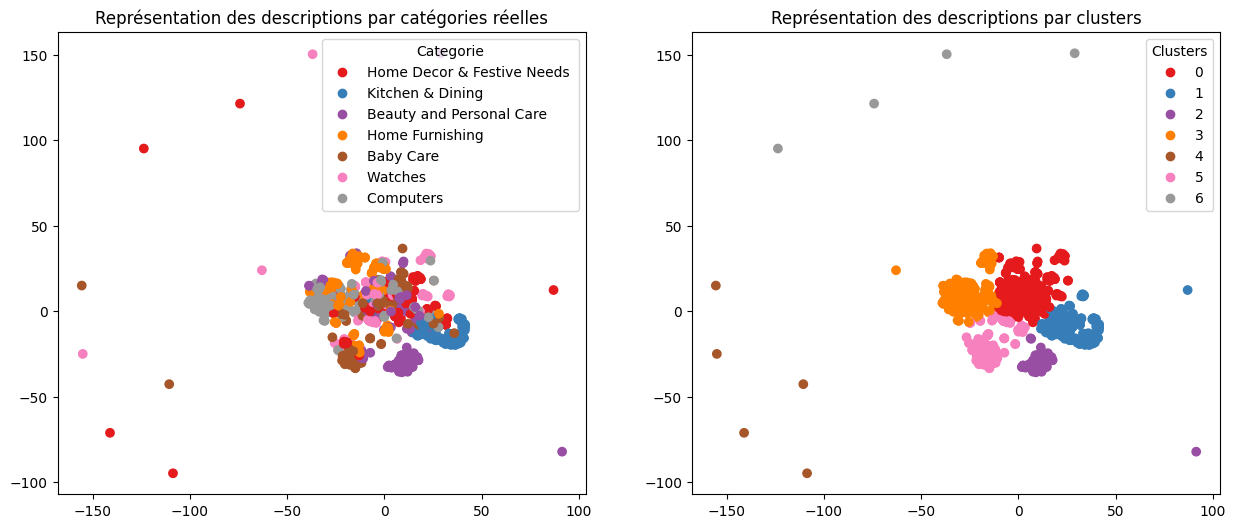

ARI :  0.2587


In [27]:
TSNE_visu_fct(X_tsne_cv, y_cat_num, labels_cv, ARI_cv)

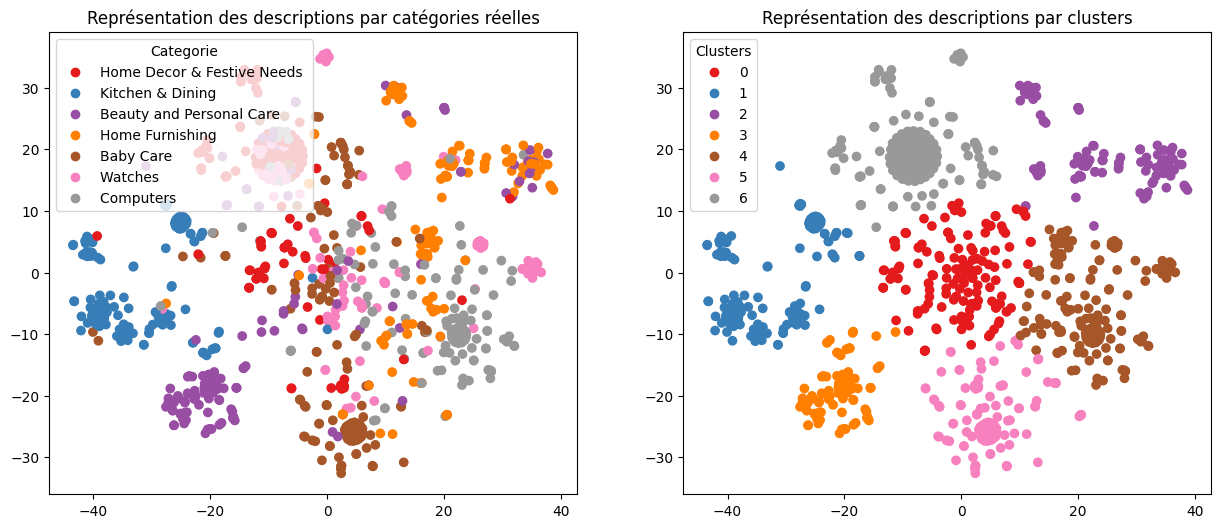

ARI :  0.3304


In [28]:
TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels_ctf, ARI_ctf)

## Word2Vec

In [30]:
import tensorflow
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [31]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 100 # adapt to length of sentences
sentences = df_com["description"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [32]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5192
Word2Vec trained


In [33]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5193


In [34]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5193, 300)


In [35]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          1557900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,557,900
Trainable params: 1,557,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [36]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [37]:
ARI_w2v, X_tsne_w2v, labels_w2v = ARI_fct(embeddings)

ARI :  0.2898 time :  7.0


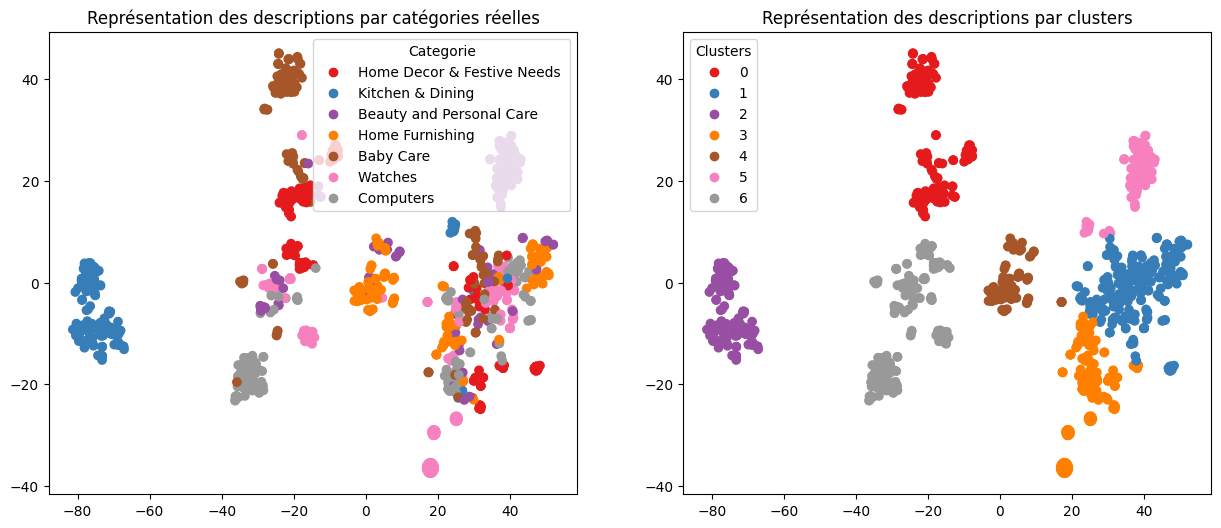

ARI :  0.2898


In [38]:
TSNE_visu_fct(X_tsne_w2v, y_cat_num, labels_w2v, ARI_w2v)

# BERT

In [40]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *
from transformers import TFGenerationMixin
# os.environ["TF_KERAS"]='1'

C:\Users\fbbou\PycharmProjects\P6_new\venv\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [42]:
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tensorflow.test.is_built_with_cuda())

2.11.0
Num GPUs Available:  0
False


## Fonctions communes

In [43]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [44]:
max_length = 100
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_com["description"].to_list()

loading configuration file config.json from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [45]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(
                                            model,
                                            model_type,
                                            sentences,
                                            max_length,
                                            batch_size,
                                            mode='HF' )

loading configuration file config.json from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 1s 1s/step
temps traitement :  139.0


In [46]:
ARI_b, X_tsne_b, labels_b = ARI_fct(features_bert)

ARI :  0.3578 time :  9.0


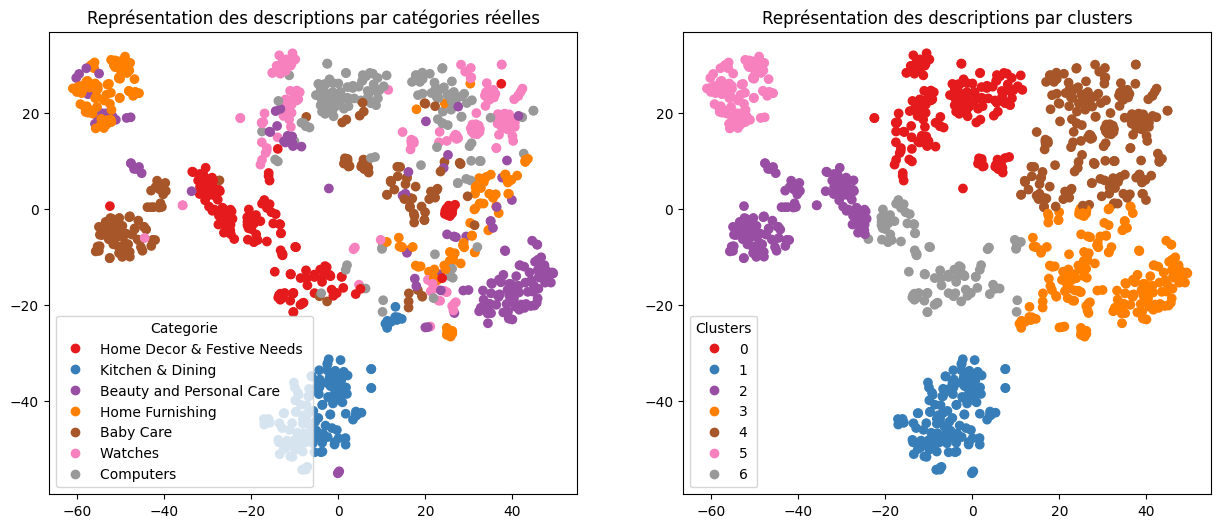

ARI :  0.3578


In [47]:
TSNE_visu_fct(X_tsne_b, y_cat_num, labels_b, ARI_b)

## BERT hub Tensorflow

### [Guide sur le Tensorflow hub](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)


In [48]:
pip install --upgrade tensorflow-hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import tensorflow_hub as hub
#import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [50]:
sentences =df_com["description"].to_list()

In [51]:
max_length = 100
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\fbbou/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  153.0


In [52]:
ARI_b2, X_tsne_b2, labels_b2 = ARI_fct(features_bert)

ARI :  0.3535 time :  10.0


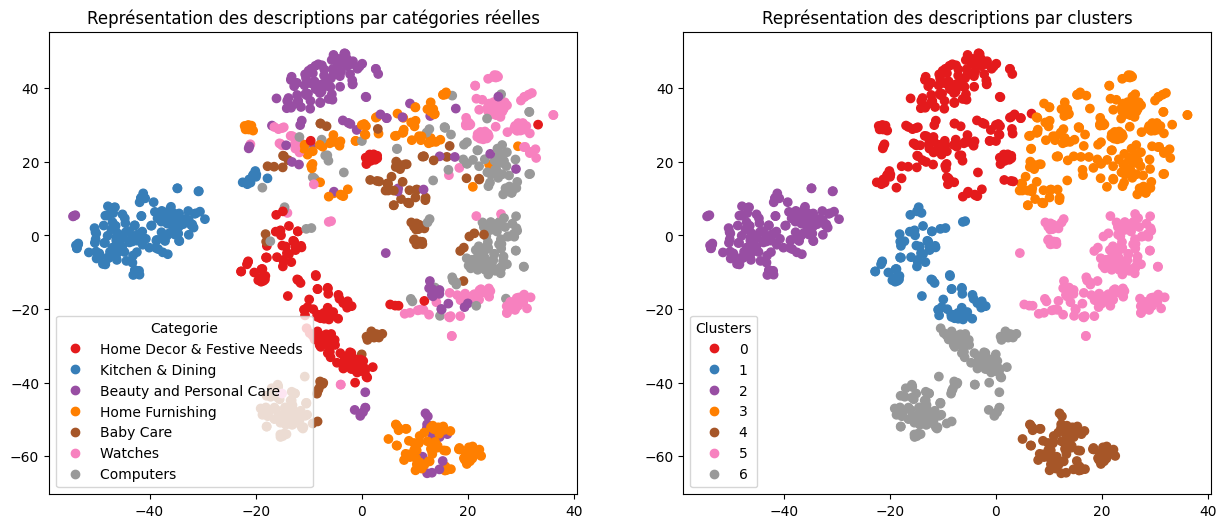

ARI :  0.3535


In [53]:
TSNE_visu_fct(X_tsne_b2, y_cat_num, labels_b2, ARI_b2)

# USE - Universal Sentence Encoder

In [54]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

#os.environ["TF_KERAS"]='1'

In [55]:
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
Num GPUs Available:  0
False


In [56]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [58]:
batch_size = 10
sentences = df_com["description"].to_list()

In [59]:
features_USE = feature_USE_fct(sentences, batch_size)

In [60]:
ARI_u, X_tsne_u, labels_u = ARI_fct(features_USE)

ARI :  0.4958 time :  11.0


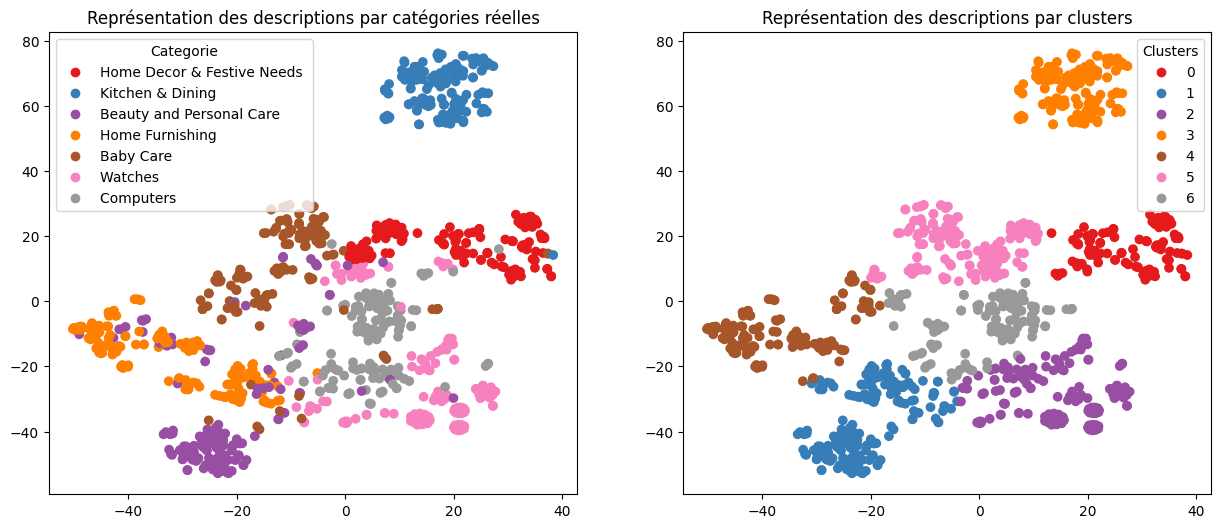

ARI :  0.4958


In [61]:
TSNE_visu_fct(X_tsne_u, y_cat_num, labels_u, ARI_u)